In [5]:
%load_ext autoreload
%autoreload 2

import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from statannotations.Annotator import Annotator

sys.path.append("../helpers")
import helpers

import constants
import TP_analysis as tp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
sns.set_palette(helpers.CUSTOM_PALETTES["custom_dark"])
sns.set_palette("tab10")

In [23]:
physician_job_titles = tp.load_physician_job_titles()

In [24]:
salary_data = tp.load_salary_data(constants.DATA_PATHS)
salary_data["gender_normed_pay"] = salary_data["total_pay"] / np.median(salary_data.query("gender == 'Men'")["total_pay"])

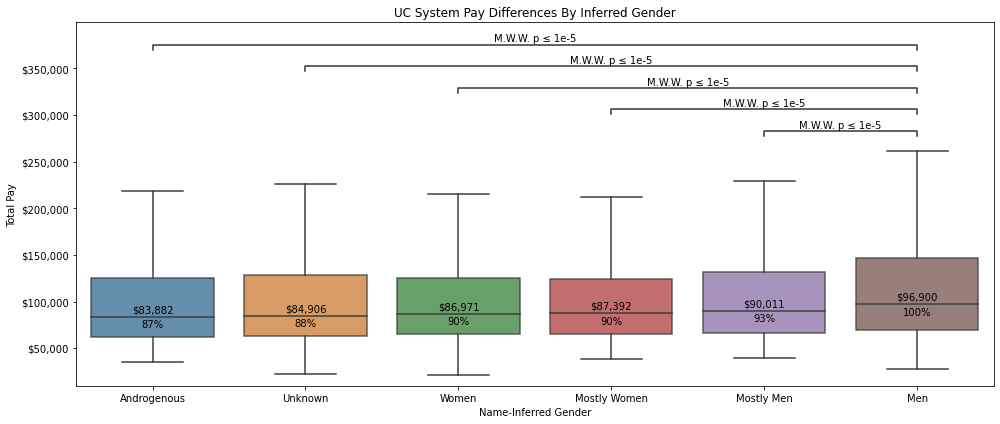

In [38]:
data, gender_medians = helpers.metric_sort(salary_data, "total_pay", "gender")
x, y ="gender", "total_pay",

fig, ax = plt.subplots(figsize=(14, 6))
sns.boxplot(data=data, x=x, y=y, showfliers=False, saturation=.6, boxprops=dict(alpha=.8))
helpers.add_plt_labels(ax, x="Name-Inferred Gender", y="Total Pay",
                       title="UC System Pay Differences by Inferred Gender")
helpers.set_money_axis(ax.yaxis)

for i, gender in enumerate(pd.unique(data["gender"])):
    median = gender_medians[gender]
    median_percent = median / gender_medians["Men"] * 100
    ax.text(i, median * 1.03, f"${median:,.0f}", ha="center", va="bottom")
    ax.text(i, median * .97, f"{median_percent:,.0f}%", ha="center", va="top")

    
pairs = [(item, "Men") for item in pd.unique(data["gender"]) if item != "Men"]

annotator = Annotator(ax, pairs, data=data, x=x, y=y)
annotator.configure(test='Mann-Whitney', text_format='simple', verbose=-1)
annotator.apply_and_annotate();

fig.tight_layout()
fig.savefig("plots/gender_disparities/uc_gender_pay_disparities.png", facecolor="#fffffe")

In [16]:
physician_salary_data = tp.load_physician_salary_data()

In [17]:
is_resident = physician_salary_data["job_title"].str.contains("resid phys")
is_instr = physician_salary_data["job_title"].str.contains("instr")
is_attending = ~(is_resident | is_instr)

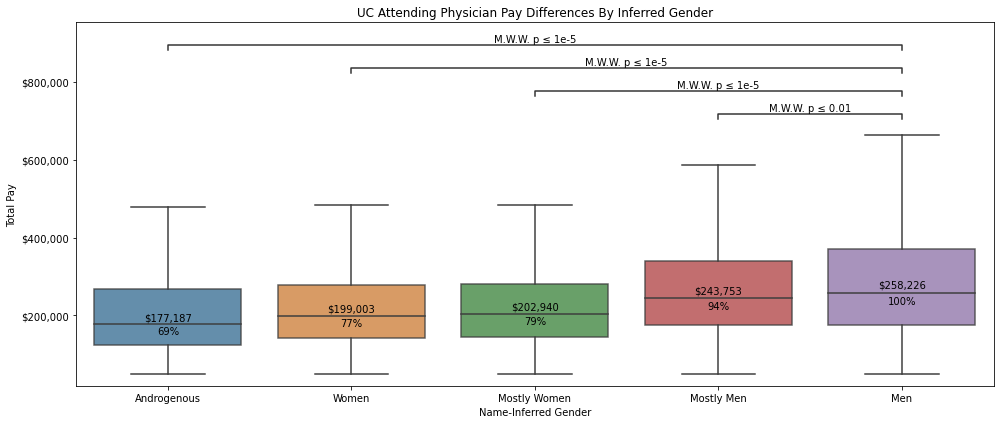

In [37]:
data = physician_salary_data.loc[is_attending].query("gender != 'Unknown'")
data, gender_medians = helpers.metric_sort(data, "total_pay", "gender")
x, y ="gender", "total_pay",

fig, ax = plt.subplots(figsize=(14, 6))
sns.boxplot(data=data, x=x, y=y, showfliers=False, saturation=.6, boxprops=dict(alpha=.8))
helpers.add_plt_labels(ax, x="Name-Inferred Gender", y="Total Pay",
                       title="UC Attending Physician Pay Differences by Inferred Gender")
helpers.set_money_axis(ax.yaxis)

for i, gender in enumerate(pd.unique(data["gender"])):
    median = gender_medians[gender]
    median_percent = median / gender_medians["Men"] * 100
    ax.text(i, median * 1.03, f"${median:,.0f}", ha="center", va="bottom")
    ax.text(i, median * .97, f"{median_percent:,.0f}%", ha="center", va="top")
    

pairs = [(item, "Men") for item in pd.unique(data["gender"]) if item != "Men"]

annotator = Annotator(ax, pairs, data=data, x=x, y=y)
annotator.configure(test='Mann-Whitney', text_format='simple', verbose=-1)
annotator.apply_and_annotate();

fig.tight_layout()
fig.savefig("plots/gender_disparities/uc_attending_gender_pay_disparities.png", facecolor="#fffffe")

In [20]:
is_resident = physician_salary_data["job_title"].str.contains("resid phys")
is_instr = physician_salary_data["job_title"].str.contains("instr")
is_attending = ~(is_resident | is_instr)

resident_data = physician_salary_data.loc[is_resident].query("year == 2019")
attending_data = physician_salary_data.loc[is_attending].query("year > 2018")

In [21]:
resident_names = resident_data["employee_name"]
resident_and_attending_names = resident_names.loc[resident_names.isin(attending_data["employee_name"])]

repeat_data = physician_salary_data.loc[physician_salary_data["employee_name"].isin(resident_and_attending_names)].sort_values(["employee_name", "year"])
duplicated_names = repeat_data["employee_name"].loc[repeat_data.duplicated(["employee_name", "year"])]
repeat_data.loc[~repeat_data["employee_name"].isin(duplicated_names)]

,employee_name,job_title,base_pay,overtime_pay,other_pay,benefits,total_pay,total_pay_&_benefits,year,gender
87420,andall lee,resid phys ii-viii/non rep,63778.0,0.0,5000.0,0.0,68778.0,68778.0,2019,Unknown
94838,andall lee,prof of clin-hcomp,137143.0,0.0,94127.0,20847.0,231270.0,252117.0,2020,Unknown
85092,arisa hernandez-morgan,resid phys/subspec 4-8/non rep,78038.0,0.0,63296.0,6520.0,141334.0,147854.0,2019,Women
90776,arisa hernandez-morgan,hs asst clin prof-hcomp,154950.0,0.0,278065.0,38226.0,433015.0,471241.0,2020,Women
86589,atthew russell,resid phys/subspec 4-8/non rep,66940.0,0.0,2747.0,8703.0,69687.0,78390.0,2019,Unknown
91891,atthew russell,hs assoc clin prof-hcomp,168166.0,0.0,203787.0,17195.0,371953.0,389148.0,2020,Unknown
85653,bi mo,resid phys/subspec 4-8/non rep,74369.0,0.0,32133.0,7407.0,106502.0,113909.0,2019,Androgenous
90921,bi mo,hs asst clin prof-hcomp,158978.0,0.0,254576.0,43052.0,413554.0,456606.0,2020,Androgenous
87769,eric chang,resid phys ii-viii/non rep,62084.0,0.0,5250.0,0.0,67334.0,67334.0,2019,Men
101676,eric chang,hs clin prof-hcomp,56391.0,0.0,0.0,5884.0,56391.0,62275.0,2020,Men
